In [4]:
# !pip install --user tables
# !pip install imblearn
# !pip3 install --force-reinstall tensorflow==2.8.0 --user 
# !pip3 install --upgrade tensorflow-gpu --user
# !pip3 install tensorflow_datasets --user
# !pip3 install numba
# !pip3 install PyWavelets
# !pip3 install imageio
# !pip3 install scikit-image

import os, h5py, re, time, pywt, imageio, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from imblearn.combine import SMOTETomek, SMOTEENN
from tqdm.auto import tqdm
tqdm.pandas()

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
# from joblib import Parallel, delayed
# import numba as nb
import tensorflow.keras.backend as K

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import keras_tuner as kt
from tensorflow import keras
from IPython.display import clear_output

# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [5]:
df = pd.read_csv('merge.csv')
df

C:\Users\Zhafran\.conda\envs\ExVodka\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise,109C.TA_201510210555_NO
1,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise,109C.TA_201511061450_NO
2,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise,109C.TA_201511070220_NO
3,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise,109C.TA_201511140515_NO
4,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise,109C.TA_201512251850_NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265652,WY,YHL,HH,44.8509,-111.1830,2691.0,400.0,manual,0.68,4.21,...,None,None,0.1253,13.93,124.9,[34.40000153 33. 36.70000076],[[1239.]],2017-06-21 09:40:43.810000,earthquake_local,YHL.WY_20170621094042_EV
1265653,WY,YHL,HH,44.8509,-111.1830,2691.0,600.0,manual,0.65,4.84,...,None,None,0.1553,17.26,121.7,[44.20000076 43.79999924 41.40000153],[[1551.]],2017-06-21 12:21:05.390000,earthquake_local,YHL.WY_20170621122104_EV
1265654,WY,YHL,HH,44.8509,-111.1830,2691.0,500.0,manual,0.65,4.82,...,None,None,0.1534,17.05,121.5,[47.5 39.90000153 42.70000076],[[1443.]],2017-06-21 12:23:40.200000,earthquake_local,YHL.WY_20170621122339_EV
1265655,WY,YHL,HH,44.8509,-111.1830,2691.0,500.0,manual,0.59,4.26,...,None,None,0.1267,14.08,126.6,[24.70000076 21.89999962 21. ],[[1322.]],2017-06-21 13:34:40.330000,earthquake_local,YHL.WY_20170621133439_EV


In [6]:
def RandomUnderSampler(df_earthquake, random_state=24, size_underSample=20000):
    np.random.seed(random_state)
    index = np.random.randint(0, len(df_earthquake)+1, size=size_underSample)
    return df_earthquake.loc[index].reset_index(drop=True)

df_noise = df[df['trace_category']=='noise'][['p_arrival_sample', 's_arrival_sample',
                                              'source_magnitude', 'trace_name', 'trace_category']]
df_noise = df_noise.reset_index(drop=True)
df_noise = df_noise.fillna(-1)

df_earthquake = df[df['trace_category']=='earthquake_local'][['p_arrival_sample', 's_arrival_sample',
                                                              'source_magnitude', 'trace_name', 'trace_category']]
df_earthquake = df_earthquake.reset_index(drop=True)
df_earthquake_sample = RandomUnderSampler(df_earthquake, size_underSample=df_noise.shape[0],
                                   random_state=24)

In [12]:
df_2 = pd.concat([df_earthquake_sample, df_noise]).reset_index(drop=True)
rate = .15/65 # 0<=rate<=1, ketika rate 1 mengambil seluruh data (balanced), ketika 0 tidak ada data yg di ambil
df_2_slice = df_2.groupby('trace_category', group_keys=False).apply(lambda x: x.sample(int(235426*rate))) 

print(f'''
{display(df_2_slice.sample(5))}

DataFrame 2 Shape       : {df_2.shape}
DataFrame 2 Sliced Shape: {df_2_slice.shape}
''')

,p_arrival_sample,s_arrival_sample,source_magnitude,trace_name,trace_category
285834,-1.0,-1.000,-1.00,B935.PB_201804270705_NO,noise
133802,400.0,2277.000,3.70,CAPN.AK_20150301171213_EV,earthquake_local
141777,500.0,790.000,2.07,LFRT.NM_20180427002342_EV,earthquake_local
27737,800.0,1062.531,0.60,TVH2.NN_20110810102051_EV,earthquake_local
170773,398.0,461.000,0.52,GDXB.NC_20110713235536_EV,earthquake_local



None

DataFrame 2 Shape       : (470852, 5)
DataFrame 2 Sliced Shape: (1086, 5)



In [14]:
df_2_slice.to_csv('Data Gempa Sample.csv', index=False)

In [15]:
X = df_2_slice.drop(columns='trace_category')
y = df_2_slice['trace_category']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size=0.5, stratify=y)
X_test, X_val, _, _ = train_test_split(X_test_val, y_test_val, train_size=0.5, stratify=y_test_val)

print(f'''
X_train Shape: {X_train.shape}
X_test  Shape: {X_test.shape}
X_val   Shape: {X_val.shape}
''')


X_train Shape: (543, 4)
X_test  Shape: (271, 4)
X_val   Shape: (272, 4)



In [16]:
def get_waveform(trace_name):
    '''
    Kolom 1: East-West Channel
    Kolom 2: North-South Channel
    Kolom 3: Z (Vertical) Channel
    '''
    filename = "merge.hdf5"
    with h5py.File(filename, "r") as f:
        data = f.get('data/'+trace_name)
        data = np.array(data)
    return data

In [17]:
def DenoiseWavelet(data, type='BayesShrink'):
    def BayesShrink():
        im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
                                  method='BayesShrink', mode='soft', 
                                  rescale_sigma=True, wavelet_levels=4)
        return im_bayes
    
    def VisuShrink():
        sigma_est = estimate_sigma(np.array(data), multichannel=True, average_sigmas=True)
        im_visu = denoise_wavelet(np.array(img), convert2ycbcr=True, multichannel=True,
                                  method='VisuShrink', mode='soft', wavelet_levels=4,
                                  sigma=sigma_est, rescale_sigma=True)
        
        return im_visu
    
    if type=='BayesShrink':
        return BayesShrink()
    elif type=='VisuShrink':
        return VisuShrink()

def create_data(data_feature, data_label, window=100, stride=10, BATCH=10):
    def create_feature():
        rs = []
        for t in tqdm(data_feature.values):
            data_l = get_waveform(t)
            data_denoise = DenoiseWavelet(data_l, type='BayesShrink')[275:1475, :]
#             print(data_denoise.shape)
            dt = tf.keras.utils.timeseries_dataset_from_array(data=data_denoise, targets=None,
                                                              sequence_length=window, sequence_stride=stride,
                                                              shuffle=False)
            if len(dt)!=1:
                return 'Masukan nilai Stride/Sub Window/Window yang lain!'
            else:
                for i in dt:
                    rs.append(i)
#         print(np.array(rs).shape)
        return tf.stack(rs)
    
    def create_label():
        label = []
        for p in tqdm(data_label.values):
            sub_label = []
            var_data = tf.keras.utils.timeseries_dataset_from_array(data=[i for i in range(275, 1476)], targets=None,
                                                                    sequence_length=100, sequence_stride=20,
                                                                    shuffle=False)

            for d in var_data:
                var_data = np.array(d)
                break

            for sub_var in var_data:
                if p in sub_var:
                    sub_label.append([1])
                else:
                    sub_label.append([0])
            label.append(sub_label)
        return np.array(label)
    
    def create_data(feature, label): 
        feature_dt = tf.data.Dataset.from_tensor_slices(feature)
        label_dt = tf.data.Dataset.from_tensor_slices(label)

        dt = tf.data.Dataset.zip((feature_dt, label_dt))
        dt = dt.cache().batch(BATCH).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
        return dt
    
    feature = create_feature()
    label = create_label()
    
    ts_dt = create_data(feature, label)
    print(f'\n{ts_dt}\n')
    return ts_dt

# dt_train = create_data(data_feature=X_train['trace_name'],
#                          data_label=X_train['p_arrival_sample'],
#                          window=100, stride=20, BATCH=56)

# dt_val = create_data(data_feature=X_val['trace_name'],
#                        data_label=X_val['p_arrival_sample'],
#                        window=100, stride=20, BATCH=56)

# dt_test = create_data(data_feature=X_test['trace_name'],
#                         data_label=X_test['p_arrival_sample'],
#                         window=100, stride=20, BATCH=56)

In [219]:
tf.keras.backend.clear_session()

class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 *((p*r)/(p + r + 1e-6)))
        
    def result(self):
        return self.f1

    def reset_state(self):
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

def model_builder(hp):
    model = keras.Sequential()
    
    model.add(tf.keras.layers.Input((56, 100, 3)))
    
    for layer_conv in range(hp.Int('layer_conv_', 1, 6)):
        hp_unit = hp.Int('units_'+str(layer_conv), 32, 256, step=32)
        hp_kernel = hp.Int('kernels_'+str(layer_conv), 1, 9, step=1)
        model.add(tf.keras.layers.Conv1D(filters=hp_unit,
                                         kernel_size=hp_kernel,
                                         activation='relu'))
        is_pool = hp.Choice("is_pool", ["avg", "max", "no"])
        if is_pool == "yes":
            with hp.conditional_scope("is_pool", ["avg"]):
                model.add(tf.keras.layers.TimeDistributed(
                    tf.keras.layers.AveragePooling1D()
                ))
        if is_pool == "max":
            with hp.conditional_scope("is_pool", ["max"]):
                model.add(tf.keras.layers.TimeDistributed(
                    tf.keras.layers.MaxPooling1D()
                ))
        
    hp_dropout_rate = hp.Float('dropout_', 0.1, 0.5, step=0.05)
    model.add(tf.keras.layers.Dropout(rate=hp_dropout_rate))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D()))
    
    for layer_gru in range(hp.Int('layer_gru_', 1, 4)):
        hp_unit_gru = hp.Int('units_'+str(layer_gru), 32, 256, step=32)
        model.add(tf.keras.layers.GRU(units=hp_unit_gru, return_sequences=True))
    
    for layer_dense in range(hp.Int('layer_dense_', 1, 3)):
        hp_unit_dense = hp.Int('units_'+str(layer_dense), 32, 128, step=32)
        hp_unit_dropout_dense = hp.Float('dropout_', 0.1, 0.5, step=0.05)
        
        model.add(tf.keras.layers.Dense(units=hp_unit_dense))
        model.add(tf.keras.layers.Dropout(rate=hp_unit_dropout_dense))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), #tfa.optimizers.LazyAdam(),
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=F1_Score())
    return model

tuner = kt.BayesianOptimization(model_builder,
                     objective=kt.Objective("val_f1_score", direction="max"),
                     max_trials=20,
                     project_name='HyperParam Tuner P-Wave -1-',
                     directory=os.path.join(os.getcwd(), 'HyperParameter Tuner Log'))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.75,
                                                 patience=5, min_lr=0.0001)
tuner.search(dt_train, validation_data=dt_val,
             epochs=25,
             use_multiprocessing=True,
             workers=4)

Trial 20 Complete [00h 14m 35s]
val_f1_score: 0.8924265503883362

Best val_f1_score So Far: 0.8954686522483826
Total elapsed time: 07h 11m 27s
INFO:tensorflow:Oracle triggered exit


In [259]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
# model.save('model-visu.h5')
model.get_weights

<bound method Model.get_weights of <keras.engine.sequential.Sequential object at 0x000001BBC8EEC850>>

In [243]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.75,
                                                 patience=5, min_lr=0.0001)
history = model.fit(dt_train, validation_data=dt_val,
                    epochs=65, callbacks=[reduce_lr, early_stop])

Epoch 1/65
158/158 [==============================] - 47s 267ms/step - loss: 0.0145 - f1_score: 0.2798 - val_loss: 0.0069 - val_f1_score: 0.5610 - lr: 0.0010
Epoch 2/65
158/158 [==============================] - 41s 259ms/step - loss: 0.0068 - f1_score: 0.6392 - val_loss: 0.0058 - val_f1_score: 0.6159 - lr: 0.0010
Epoch 3/65
158/158 [==============================] - 39s 246ms/step - loss: 0.0057 - f1_score: 0.7178 - val_loss: 0.0049 - val_f1_score: 0.7123 - lr: 0.0010
Epoch 4/65
158/158 [==============================] - 40s 251ms/step - loss: 0.0051 - f1_score: 0.7569 - val_loss: 0.0042 - val_f1_score: 0.7737 - lr: 0.0010
Epoch 5/65
158/158 [==============================] - 40s 256ms/step - loss: 0.0048 - f1_score: 0.7773 - val_loss: 0.0046 - val_f1_score: 0.7138 - lr: 0.0010
Epoch 6/65
158/158 [==============================] - 40s 252ms/step - loss: 0.0045 - f1_score: 0.7963 - val_loss: 0.0038 - val_f1_score: 0.8025 - lr: 0.0010
Epoch 7/65
158/158 [==============================] 

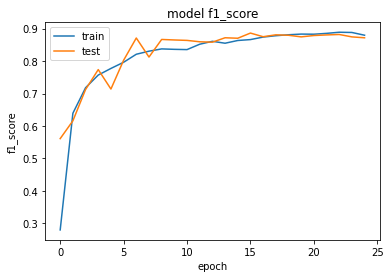

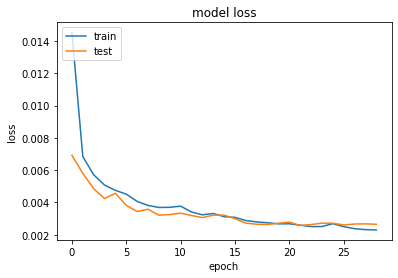

In [244]:
# summarize history for precision
plt.plot(history.history['f1_score'][:25])
plt.plot(history.history['val_f1_score'][:25])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [864]:
y_pred = load_model.predict(dt_test)

def get_predict_p(arr, threshold=.5, types='Highest'):
    arr = arr.reshape(-1)
    
    if types=='Highest':
        if np.max(arr)>=threshold:
            return np.argmax(arr)*20+275
        else:
            return -1
    elif types=='Early':
        for i, p_prob in enumerate(arr):
            if p_prob>=threshold:
                return i*20+275
        else:
            return -1
    elif types=='Late':
        i_thres = None
        for i, p_prob in enumerate(arr):
            if p_prob>=threshold:
                i_thres = i
        if i_thres!=None:
            return i_thres*20+275
        else:
            return -1
        
        
def sample_p(threshold):
    clear_output()
    idx_ = np.random.randint(0, len(X_test['p_arrival_sample']))
    trace_ = X_test['trace_name'].iloc[idx_]
    data_ = get_waveform(trace_)[275:1475]
    p_true_ = X_test['p_arrival_sample'].iloc[idx_]/100
    
    p_pred_high_ = get_predict_p(arr=y_pred[idx_], threshold=threshold, types='Highest')/100
    p_pred_early_ = get_predict_p(arr=y_pred[idx_], threshold=threshold, types='Early')/100
    p_pred_late_ = get_predict_p(arr=y_pred[idx_], threshold=threshold, types='Late')/100

    print(f'Index-{idx_}, P-True: {p_true_}')
    print(f'P-Predict-High : {p_pred_high_}')    
    print(f'P-Predict-Early: {p_pred_early_}')    
    print(f'P-Predict-Late : {p_pred_late_}\n')    

        
    if p_true_!=(-1/100):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(311)         
        
        plt.plot(np.linspace(275, 1475, 1200)/100, np.mean(data_, axis=-1), 'k')
        legend_properties = {'weight':'bold'}    
        plt.tight_layout()
        ymin, ymax = ax.get_ylim()
        
        p_true = plt.vlines(p_true_, ymin, ymax, color='b', linewidth=2, label='P-Arrival')
        p_pred_high = plt.vlines(p_pred_high_, ymin, ymax, color='r',
                                 linewidth=2, label='P-Predict-High')
        p_pred_early = plt.vlines(p_pred_early_, ymin, ymax, color='r',
                                  linewidth=2, label='P-Predict-Early', linestyles='dashed')
        p_pred_late = plt.vlines(p_pred_late_, ymin, ymax, color='r',
                                 linewidth=2, label='P-Predict-Late', linestyles='dotted')

        plt.legend(handles=[p_true, p_pred_high, p_pred_early, p_pred_late],
                   loc = 'upper right', borderaxespad=0., prop=legend_properties)        
        plt.ylabel('Mean of All Channel', fontsize=12) 
#         ax.set_xticklabels(np.linspace(275, 1475, 1200).round(0)/100) 
#         ax.set_xticklabels(np.linspace(275, 1475, 1200))

    else:
        sample_p(threshold)

Index-18, P-True: 4.0
P-Predict-High : 3.15
P-Predict-Early: 3.15
P-Predict-Late : 3.95



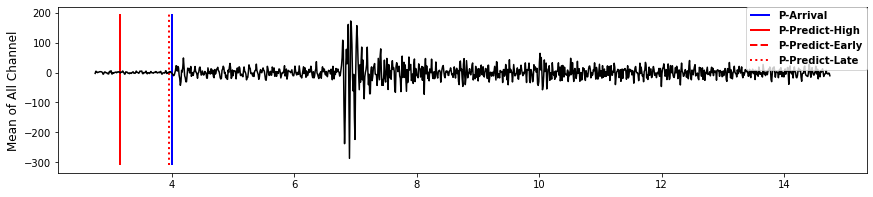

In [898]:
sample_p(.5)

# Load Model

In [286]:
# === LOAD SAVEDMODEL ===

class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 *((p*r)/(p + r + 1e-6)))
        
    def result(self):
        return self.f1

    def reset_state(self):
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

load_model = tf.keras.models.load_model(os.path.join(os.getcwd(), 'Model Checkpoint', 'v1.1 (P-Wave 1 Final)'),
                                        custom_objects={'F1_Score':F1_Score})

# Evaluate On Noise Data

In [795]:
dt_noise = create_data(data_feature=df_noise.sample(56)['trace_name'],
                         data_label=df_noise.sample(56)['p_arrival_sample'],
                         window=100, stride=20, BATCH=56)

y_true = np.concatenate([y for x, y in dt_noise], axis=0).reshape(-1)

  0%|          | 0/56 [00:00<?, ?it/s]C:\Users\Zhafran\AppData\Local\Temp/ipykernel_17564/522875790.py:3: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
100%|██████████| 56/56 [00:02<00:00, 25.60it/s]


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 56, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 56, 1), dtype=tf.int32, name=None))>



In [326]:
def threshold(x):
    if x>=.5:
        return 1
    else:
        return 0
    
y_pred = load_model.predict(dt_noise)
y_pred = np.vectorize(threshold)(y_pred).reshape(-1)

Semua Noise berhasil di prediksi bahwa mereka adalah noise bukan earthquake


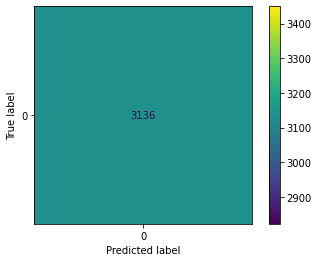

In [327]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print('Semua Noise berhasil di prediksi bahwa mereka adalah noise bukan earthquake')

In [328]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3136

    accuracy                           1.00      3136
   macro avg       1.00      1.00      1.00      3136
weighted avg       1.00      1.00      1.00      3136



# Evaluate On Test Data

In [818]:
def threshold(x):
    if x>=.5:
        return 1
    else:
        return 0
    
y_true = np.concatenate([y for x, y in dt_test], axis=0).reshape(-1)
y_pred = load_model.predict(dt_test)
y_pred = np.vectorize(threshold)(y_pred).reshape(-1)

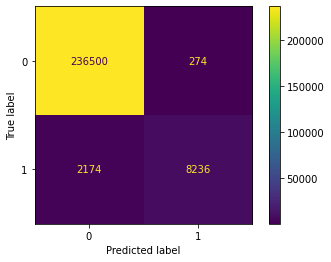

In [330]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# print('Semua Noise berhasil di prediksi bahwa mereka adalah noise bukan earthquake')

In [331]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    236774
           1       0.97      0.79      0.87     10410

    accuracy                           0.99    247184
   macro avg       0.98      0.90      0.93    247184
weighted avg       0.99      0.99      0.99    247184



In [249]:
# Save the entire model as a SavedModel.

# model.save(os.path.join(os.getcwd(), 'Model Checkpoint', 'v1.1 (P-Wave 1 Final)'))
# model.save_weights(os.path.join(os.getcwd(), 'Model Checkpoint', 'v1.1.Weight (P-Wave 1 Final)', 'Pretrained-Weight.h5'))

In [493]:
# # === CONTOH LOAD SAVEDMODEL ===

# class F1_Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super().__init__(name=name, **kwargs)
#         self.f1 = self.add_weight(name='f1', initializer='zeros')
#         self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
#         self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)
        
#     def update_state(self, y_true, y_pred, sample_weight=None):
#         p = self.precision_fn(y_true, y_pred)
#         r = self.recall_fn(y_true, y_pred)
#         self.f1.assign(2 *((p*r)/(p + r + 1e-6)))
        
#     def result(self):
#         return self.f1

#     def reset_state(self):
#         self.precision_fn.reset_states()
#         self.recall_fn.reset_states()
#         self.f1.assign(0)

# load_model = tf.keras.models.load_model(os.path.join(os.getcwd(), 'Model Checkpoint', 'v1'),
#                                         custom_objects={'F1_Score':F1_Score})

In [35]:
# %%time
# tf_data_path_train = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v1', 'Train')
# tf_data_path_test = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v1', 'Test')
# tf_data_path_val = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v1', 'Val')

# # Training
# tf.data.experimental.save(
#     dt_train, tf_data_path_train, compression='GZIP'
# )
# with open(tf_data_path_train + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
#     pickle.dump(dt_train.element_spec, out_)
    
# # Testing
# tf.data.experimental.save(
#     dt_test, tf_data_path_test, compression='GZIP'
# )
# with open(tf_data_path_test + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
#     pickle.dump(dt_test.element_spec, out_)
    

# # Validation
# tf.data.experimental.save(
#     dt_val, tf_data_path_val, compression='GZIP'
# )
# with open(tf_data_path_val + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
#     pickle.dump(dt_val.element_spec, out_)

Wall time: 25.3 s


In [532]:
# # Load Prefetch Dataset

# %%time
# tf_data_path = os.path.join(os.getcwd(), 'Prefetch Dataset', 'Testing Save n Load')
# with open(tf_data_path + '/element_spec', 'rb') as in_:
#     es = pickle.load(in_)

# loaded = tf.data.experimental.load(
#     tf_data_path, es, compression='GZIP'
# )

Wall time: 11 ms


In [905]:
a = np.random.random(size=(56,48,3))
b = np.random.random(size=(56,48,3))

In [907]:
np.concatenate((a,b), axis=1).shape

(56, 96, 3)